# Joseph Korban's Notebook

## Goal: DL Model for 7 days


#### Preliminary Steps

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import os

import tensorflow as tf


In [2]:
df = pd.read_csv('/Users/joekorban/code/J0eDub/crypto_market_assistant/raw_data/non_Scaled_full.csv')
df_jk = df.drop(columns=['Unnamed: 0','volume BTC','twitter_favourites','reddit_active_users','twitter_followers'])
df_jk


,open,high,low,close,volume USD,FAGI_score,scored_title,scored_text,average_score,reddit_subscribers,reddit_comments_per_day,FAGI_sentiment_encoded
0,4261.48,4485.39,4200.74,4285.08,3.454770e+06,50.0,0.000000,0.000000,0.000000,1.000000e+03,699.824346,2.0
1,4285.08,4371.52,3938.77,4108.37,5.086958e+06,50.0,0.000000,0.000000,0.000000,1.419855e+03,699.824346,2.0
2,4108.37,4184.69,3850.00,4139.98,1.549484e+06,50.0,0.000000,0.000000,0.000000,1.839711e+03,699.824346,2.0
3,4139.98,4211.08,4032.62,4086.29,1.930364e+06,50.0,0.000000,0.000000,0.000000,2.259566e+03,699.824346,2.0
4,4069.13,4119.62,3911.79,4016.00,2.797232e+06,50.0,0.000000,0.000000,0.000000,2.679422e+03,699.824346,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2292,37780.67,37814.63,37150.00,37447.43,7.973212e+08,73.0,0.858534,0.957825,0.908179,2.593963e+06,107.410000,3.0
2293,37447.42,37569.23,36707.00,37242.70,1.112557e+09,66.0,0.684048,0.937447,0.810748,2.594931e+06,102.060000,3.0
2294,37242.70,38377.00,36868.41,37818.87,1.414360e+09,68.0,0.640768,0.311340,0.476054,2.594931e+06,699.824346,3.0
2295,37818.88,38450.00,37570.00,37854.64,1.252587e+09,72.0,0.676125,0.648727,0.662426,2.594931e+06,699.824346,3.0


#### Assignments:
- Targets  
- Number of targets
- Number of features


In [3]:
# Can change later

N_FEATURES = df_jk.shape[1]  # All features other than time
N_TARGETS = 1                      # Prediciting only 1 target (close price)
TARGET = 'close'


## Preparing the dataset for DL Model

### Step 1. Creating many folds

#### Assignments:
- Fold Length   
- Fold Size
- Train Test Ratio


In [4]:
# Can change later

# Since we have data for about 6.3 years, and bitcoin is volatile, we will asssume fold lengths of 1 quarter
# 60 daily for training and 30 for testing

FOLD_LENGTH = 90      # Assume fold length of 1 quarter
FOLD_STRIDE = 10      # Assume stride every 10 days
TRAIN_TEST_RATIO = 0.67   # Two-thirds split ratio


#### * Implement the Get Folds Function:
- Takes in df, fold length, fold stride
- Returns a list of folds (each fold being a dataframe)

In [5]:
# Goes through the dataframe and creates equal sized folds of FOLD_LENGTH
# starting at 0 and at each FOLD_STRIDE until it crosses len(df)

def get_folds(df: pd.DataFrame,
    fold_length: int,
    fold_stride: int) -> list[pd.DataFrame]:

    folds = []
    for index in range(0, fold_length, fold_stride):
        if index + fold_length > len(df):
            break
        fold = df.iloc[index:index + fold_length,:]
        folds.append(fold)
    return folds


In [6]:
folds = (get_folds(df_jk,FOLD_LENGTH,FOLD_STRIDE))
print(f'Number of folds created were {len(folds)}')
print(f'Each with a shape equal to {folds[0].shape}.')


Number of folds created were 9
Each with a shape equal to (90, 12).


### Step 2. Temporal Train Test Split for one fold

#### Focusing on the last fold for now

In [7]:
fold = folds[-1]


#### Assignments:
- Input Length : Selected period selected for forecasting
- Output Length : Selected period we want to predict


In [8]:
# Can change later

INPUT_LENGTH = 7          # We can assume 7 days for a forecating period
OUTPUT_LENGTH = 7           # If we want predict one week ahead
TEMP_TRAIN_TEST_RATIO = 0.8 # How we want to split each fold (can be same as train test ratio)


#### * Implement the Temporal Train Test Split Function:
- Takes in a fold, temporal train test ratio, input length
- Returns a tuple of (fold_train, fold_test), each as a dataframe

In [9]:
# Splitting one fold into train and test chronologically,
# so we can later sample many (Xi,yi) pairs (input and output lengths)

def temporal_train_test_split(fold:pd.DataFrame,
                            temp_train_test_ratio: float,
                            input_length: int) -> tuple[pd.DataFrame]:
    # Train set
    last_train_index = round(temp_train_test_ratio * len(fold))
    fold_train = fold.iloc[0:last_train_index, :]

    #Test Set
    first_test_index = last_train_index - input_length
    fold_test = fold.iloc[first_test_index:, :]

    return (fold_train,fold_test)


In [10]:
(fold_train, fold_test) = temporal_train_test_split(fold, TEMP_TRAIN_TEST_RATIO, INPUT_LENGTH)


In [11]:
fold_train.shape, fold_test.shape


((72, 12), (25, 12))

### Step 3. Create (X, y) sequences

### Option 1. Random Sampling

#### Now that we split our fold into trian and test we have to create 2 functions
- One that will return a single sequence of (Xi, yi) (from fold train for training, and from fold test for evaluating)
- Another that will call the first function many times over creating 3-D arrays of multiple sequences (X, y)

#### * Implement the Get (Xi, yi) function (using the random method):
- Takes in a fold, input length ,output length
- Returns a single sequence of (Xi, yi) as a 2-D DataFrame

In [12]:
STRIDE = 3


In [13]:
# Given a fold (could be train fold for testing or test fold for evaluating),
# it will return a sequence of (Xi,yi) based on input and output lengths,
# starting from a random point.

def get_Xi_yi_7(first_index: int,
              fold: pd.DataFrame,
              input_length: int,
              output_length: int) -> tuple[np.ndarray, np.ndarray]:
    '''
    - extracts one sequence from a fold
    - returns a pair (Xi, yi) with:
        * len(Xi) = `input_length` and Xi starting at first_index
        * len(yi) = `output_length`
        * last_Xi and first_yi separated by the gap = horizon -1
    '''

    Xi_start = first_index
    Xi_last = Xi_start + input_length
    yi_start = Xi_last
    yi_last = yi_start + output_length

    Xi = fold[Xi_start:Xi_last]
    yi = fold[yi_start:yi_last][TARGET]

    return (Xi, yi)


In [14]:
def get_X_y_7(fold: pd.DataFrame,             input_length: int,
             output_length: int,
             stride: int,
             shuffle=True) -> tuple[np.ndarray, np.ndarray]:
    """
    - Uses `data`, a 2D-array with axis=0 for timesteps, and axis=1 for (targets+covariates columns)
    - Returns a Tuple (X,y) of two ndarrays :
        * X.shape = (n_samples, input_length, n_covariates)
        * y.shape =
            (n_samples, output_length, n_targets) if all 3-dimensions are of size > 1
            (n_samples, output_length) if n_targets == 1
            (n_samples, n_targets) if output_length == 1
            (n_samples, ) if both n_targets and lenghts == 1
    - You can shuffle the pairs (Xi,yi) of your fold
    """
    X = []
    y = []

    # Scanning the fold/data entirely with a certain stride
    for i in range(0, len(fold), stride):
        ## Extracting a sequence starting at index_i
        Xi, yi = get_Xi_yi_7(first_index=i,
                            fold=fold,
                            input_length=input_length,
                            output_length=output_length)
        ## Exits loop as soon as we reach the end of the dataset
        if len(yi) < output_length:
            break
        X.append(Xi)
        y.append(yi)

    X = np.array(X)
    y = np.array(y)
    y = np.squeeze(y)

    if shuffle:
        idx = np.arange(len(X))
        np.random.shuffle(idx)
        X = X[idx]
        y = y[idx]

    return X, y


In [15]:
X_train, y_train = get_X_y_7(fold=fold_train,
                           input_length=INPUT_LENGTH,
                           output_length=OUTPUT_LENGTH,
                           stride=STRIDE)
X_test, y_test = get_X_y_7(fold=fold_test,
                         input_length=INPUT_LENGTH,
                         output_length=OUTPUT_LENGTH,
                         stride=STRIDE)

print("Shapes for the training set:")
print(f"X_train.shape = {X_train.shape}, y_train.shape = {y_train.shape}")

print("Shapes for the test set:")
print(f"X_test.shape = {X_test.shape}, y_test.shape = {y_test.shape}")


Shapes for the training set:
X_train.shape = (20, 7, 12), y_train.shape = (20, 7)
Shapes for the test set:
X_test.shape = (4, 7, 12), y_test.shape = (4, 7)


## Modeling

In [16]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers, metrics
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Lambda
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras import regularizers


### Step 1. Building a Baseline (dummy) model for comparisons

#### * Initialize the Baseline Model function based on last seen value

In [17]:
y_train.shape , y_test.shape


((20, 7), (4, 7))

In [18]:

def last_seen_value_baseline(X, y):

    # How many values do you want to predict in the future ?
    output_length = y.shape[-1]

    # For each sequence, let's consider the last seen value
    # and only the close column
    last_seen_values = X[:,-1, 3].reshape(-1,1)

    # We need to duplicate these values as many times as output_length
    repeated = np.repeat(last_seen_values, axis = 1, repeats = output_length)

    MAE = np.mean(np.abs(y - repeated))
    MAPE = np.mean(abs((y - repeated) / y)) * 100
    SMAPE = np.mean((abs(y - repeated)) / ((y + repeated)/2))* 100
    return MAE, MAPE, SMAPE , repeated


In [19]:
baseline_score = last_seen_value_baseline(X_test, y_test)
baseline_score


(910.6185714285717,
 8.146962462523225,
 7.658102616824383,
 array([[11349.99, 11349.99, 11349.99, 11349.99, 11349.99, 11349.99,
         11349.99],
        [11530.  , 11530.  , 11530.  , 11530.  , 11530.  , 11530.  ,
         11530.  ],
        [13539.93, 13539.93, 13539.93, 13539.93, 13539.93, 13539.93,
         13539.93],
        [10961.97, 10961.97, 10961.97, 10961.97, 10961.97, 10961.97,
         10961.97]]))

### Step 2. Building an LSTM Model

#### * Define the SMAPE Metric

In [20]:
def smape(y_true, y_pred):
    return tf.reduce_mean(((abs(y_true - y_pred)) / ((y_true + y_pred)/2))* 100, axis=-1)


#### * Initialize the LSTM Model function

In [21]:
def init_model(X_train, y_train):

    # adam = optimizers.Adam(learning_rate=0.02)

    initial_learning_rate = 0.1 # Default Adam

    lr_schedule = ExponentialDecay(
    initial_learning_rate,
    decay_steps = 500,    # every 500 iterations
    decay_rate = 0.5)      # we multiply the learning rate by the decay_rate


    adam = optimizers.Adam(learning_rate=lr_schedule)


    #reg_l2 = regularizers.L2(0.5)

    output_length = y_train.shape[1]

    normalizer = Normalization()
    normalizer.adapt(X_train)

    model = models.Sequential()

    model.add(normalizer)

    model.add(layers.LSTM(64,
                          activation='tanh',
                          return_sequences = True,
                          ))
    model.add(layers.LSTM(32,
                          activation='tanh',
                          return_sequences = True
                          ))
    model.add(layers.LSTM(16,
                          activation='tanh',
                          return_sequences = False
                          ))
    model.add(layers.Dense(10, activation='elu'
                           ))

    model.add(layers.Dense(output_length, activation='linear'))

    model.compile(loss='mse', optimizer=adam, metrics=["mse",'mae','mape',smape])

    return model


In [22]:
def fit_model(model: tf.keras.Model, verbose=1) -> tuple[tf.keras.Model, dict]:

    es = EarlyStopping(monitor = "val_loss",
                      patience = 20,
                      mode = "min",
                      restore_best_weights = True)


    history = model.fit(X_train, y_train,
                        validation_split = 0.3,
                        shuffle = False,
                        batch_size = 16,
                        epochs = 200,
                        callbacks = [es],
                        verbose = verbose)

    return model, history


#### * Define the plot history function

In [23]:
def plot_history(history):

    fig, ax = plt.subplots(1,2, figsize=(20,7))
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('MSE')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['Train', 'Validation'], loc='best')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)

    ax[1].plot(history.history['mae'])
    ax[1].plot(history.history['val_mae'])
    ax[1].set_title('MAE')
    ax[1].set_ylabel('MAE')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Validation'], loc='best')
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)

    return ax


In [24]:
model = init_model(X_train, y_train)

model, history = fit_model(model)


Epoch 1/200
1/1 [==============================] - 3s 3s/step - loss: 194625232.0000 - mse: 194625232.0000 - mae: 13520.0625 - mape: 100.0000 - smape: 199.9998 - val_loss: 151331456.0000 - val_mse: 151331456.0000 - val_mae: 11874.2070 - val_mape: 99.9888 - val_smape: 199.9553
Epoch 2/200
1/1 [==============================] - 0s 29ms/step - loss: 194576272.0000 - mse: 194576272.0000 - mae: 13518.3281 - mape: 99.9868 - smape: 199.9471 - val_loss: 151264880.0000 - val_mse: 151264880.0000 - val_mae: 11871.3486 - val_mape: 99.9621 - val_smape: 199.8486
Epoch 3/200
1/1 [==============================] - 0s 28ms/step - loss: 194515552.0000 - mse: 194515552.0000 - mae: 13516.0088 - mape: 99.9675 - smape: 199.8698 - val_loss: 151196816.0000 - val_mse: 151196816.0000 - val_mae: 11868.4834 - val_mape: 99.9358 - val_smape: 199.7434
Epoch 4/200
1/1 [==============================] - 0s 29ms/step - loss: 194443264.0000 - mse: 194443264.0000 - mae: 13513.3076 - mape: 99.9456 - smape: 199.7824 - val_

array([<Axes: title={'center': 'MSE'}, xlabel='Epoch', ylabel='Loss'>,
       <Axes: title={'center': 'MAE'}, xlabel='Epoch', ylabel='MAE'>],
      dtype=object)

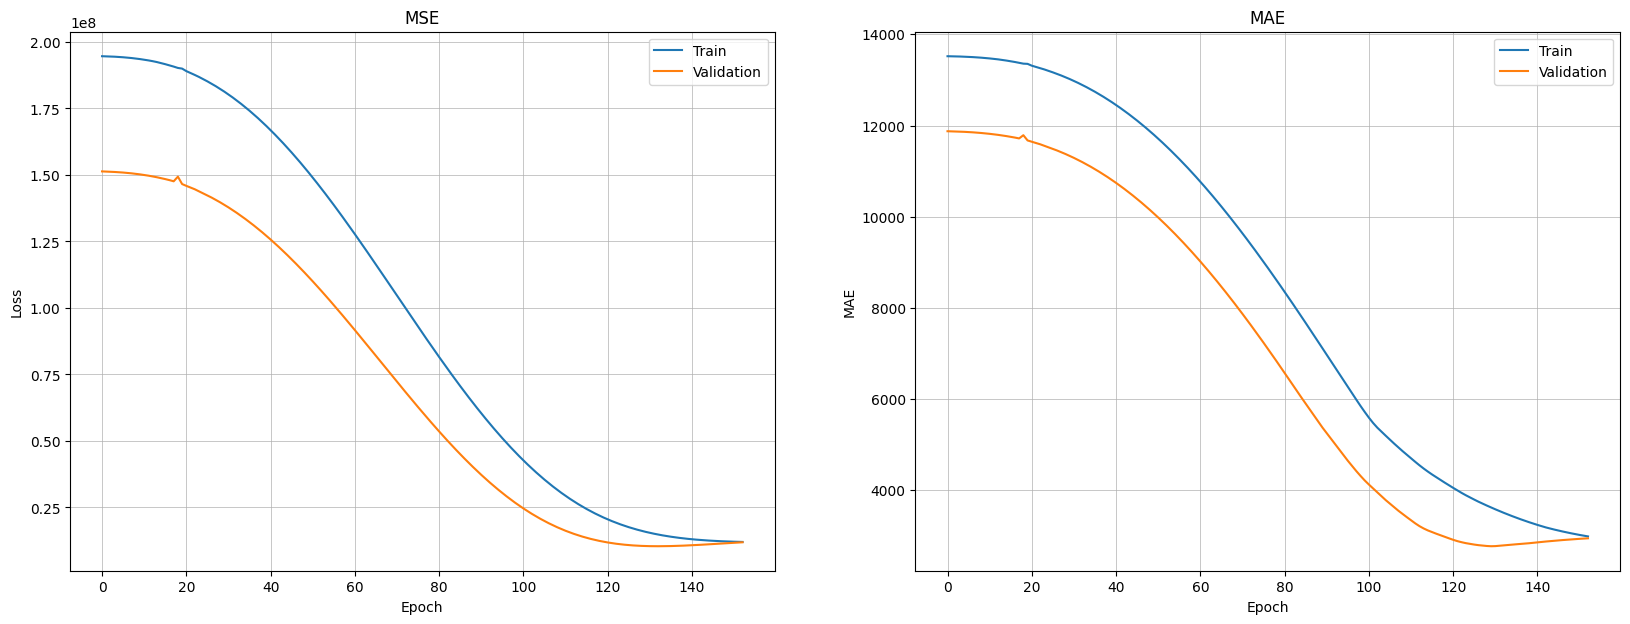

In [25]:
plot_history(history)


In [26]:
res = model.evaluate(X_test,y_test)
res


1/1 [==============================] - 0s 18ms/step - loss: 736670.5000 - mse: 736670.5000 - mae: 767.9648 - mape: 6.9403 - smape: 6.6872


[736670.5, 736670.5, 767.9647827148438, 6.940289497375488, 6.687244415283203]

In [27]:
print(f'Improvement over baseline model is {((baseline_score[0] - res[2])/baseline_score[0])*100} %')


Improvement over baseline model is 15.665591850376362 %


In [28]:
X_test.shape , X_train.shape, y_test.shape, y_train.shape


((4, 7, 12), (20, 7, 12), (4, 7), (20, 7))

In [29]:
model.predict(X_test)[2] , y_test[2]


1/1 [==============================] - 1s 548ms/step


(array([11998.297, 11915.489, 11923.835, 11753.258, 11757.283, 11970.278,
        11810.08 ], dtype=float32),
 array([10900.  , 10988.79, 10961.97, 11474.98, 12799.94, 11530.  ,
        10760.05]))

In [30]:
correct_movements = 0
incorrect_movements = 0
for j in range(y_test.shape[0]):
  for i in range(y_test.shape[1]-1):
    if (model.predict(X_test)[j][i+1] > model.predict(X_test)[j][i] and y_test[j][i+1] > y_test[j][i]) or (model.predict(X_test)[j][i+1] < model.predict(X_test)[j][i] and y_test[j][i+1] < y_test[j][i]):
      correct_movements+=1
    else:
      incorrect_movements+=1
print (f'correct predictions ={correct_movements}')
print (f'incorrect prediction = {incorrect_movements}')


1/1 [==============================] - 0s 13ms/step
correct predictions =11
incorrect prediction = 13


#### All this was for one fold, now we need to Cross validate on all folds

### Step 3. Cross Validation

#### * Funtion to Cross Validate for Baseline and LSTM Models in for loop

In [31]:
def cross_validate_baseline_and_lstm():
    '''
    This function cross-validates
    - the "last seen value" baseline model
    - the RNN model
    '''

    list_of_mae_baseline_model = []
    list_of_mae_recurrent_model = []

    # 0 - Creating folds
    # =========================================
    folds = get_folds(df_jk, FOLD_LENGTH, FOLD_STRIDE)

    for fold_id, fold in enumerate(folds):

        # 1 - Train/Test split the current fold

        (fold_train, fold_test) = temporal_train_test_split(fold, TRAIN_TEST_RATIO, INPUT_LENGTH)

        X_train, y_train = get_X_y_7(fold=fold_train,
                           input_length=INPUT_LENGTH,
                           output_length=OUTPUT_LENGTH,
                           stride=STRIDE)
        X_test, y_test = get_X_y_7(fold=fold_train,
                           input_length=INPUT_LENGTH,
                           output_length=OUTPUT_LENGTH,
                           stride=STRIDE)

        # 2 - Modelling

        ##### Baseline Model
        mae_baseline = last_seen_value_baseline(X_test, y_test)[0]
        list_of_mae_baseline_model.append(mae_baseline)
        print("-"*50)
        print(f"MAE baseline fold n°{fold_id} = {round(mae_baseline, 2)}")

        ##### LSTM Model
        model = init_model(X_train, y_train)
        history = fit_model(model)
        res = model.evaluate(X_test, y_test, verbose=0)
        mae_lstm = res[2]
        list_of_mae_recurrent_model.append(mae_lstm)
        print(f"MAE LSTM fold n°{fold_id} = {round(mae_lstm, 2)}")

        ##### Comparison LSTM vs Baseline for the current fold
        print(f"🏋🏽‍♂️ improvement over baseline: {round((1 - (mae_lstm/mae_baseline))*100,2)} % \n")

    return list_of_mae_baseline_model, list_of_mae_recurrent_model


In [32]:
mae_baselines, mae_lstms = cross_validate_baseline_and_lstm()


--------------------------------------------------
MAE baseline fold n°0 = 307.27
Epoch 1/200
1/1 [==============================] - 3s 3s/step - loss: 194626768.0000 - mse: 194626768.0000 - mae: 13520.1152 - mape: 100.0003 - smape: 200.0012 - val_loss: 151338096.0000 - val_mse: 151338096.0000 - val_mae: 11874.5049 - val_mape: 99.9919 - val_smape: 199.9675
Epoch 2/200
1/1 [==============================] - 0s 29ms/step - loss: 194600992.0000 - mse: 194600992.0000 - mae: 13519.1641 - mape: 99.9927 - smape: 199.9710 - val_loss: 151303312.0000 - val_mse: 151303312.0000 - val_mae: 11873.0576 - val_mape: 99.9788 - val_smape: 199.9151
Epoch 3/200
1/1 [==============================] - 0s 28ms/step - loss: 194561840.0000 - mse: 194561840.0000 - mae: 13517.7158 - mape: 99.9812 - smape: 199.9247 - val_loss: 151260048.0000 - val_mse: 151260048.0000 - val_mae: 11871.2607 - val_mape: 99.9625 - val_smape: 199.8502
Epoch 4/200
1/1 [==============================] - 0s 28ms/step - loss: 194513264.000

MAE LSTM fold n°0 = 7599.97
🏋🏽‍♂️ improvement over baseline: -2373.39 % 

--------------------------------------------------
MAE baseline fold n°1 = 343.83
Epoch 1/200
1/1 [==============================] - 3s 3s/step - loss: 194625696.0000 - mse: 194625696.0000 - mae: 13520.0771 - mape: 100.0001 - smape: 200.0002 - val_loss: 151335840.0000 - val_mse: 151335840.0000 - val_mae: 11874.4102 - val_mape: 99.9909 - val_smape: 199.9637
Epoch 2/200
1/1 [==============================] - 0s 30ms/step - loss: 194598320.0000 - mse: 194598320.0000 - mae: 13519.0684 - mape: 99.9920 - smape: 199.9681 - val_loss: 151298432.0000 - val_mse: 151298432.0000 - val_mae: 11872.8369 - val_mape: 99.9765 - val_smape: 199.9060
Epoch 3/200
1/1 [==============================] - 0s 28ms/step - loss: 194555872.0000 - mse: 194555872.0000 - mae: 13517.4951 - mape: 99.9794 - smape: 199.9177 - val_loss: 151237024.0000 - val_mse: 151237024.0000 - val_mae: 11870.2373 - val_mape: 99.9524 - val_smape: 199.8099
Epoch 4/200

MAE LSTM fold n°1 = 7347.81
🏋🏽‍♂️ improvement over baseline: -2037.03 % 

--------------------------------------------------
MAE baseline fold n°2 = 338.86
Epoch 1/200
1/1 [==============================] - 3s 3s/step - loss: 194624896.0000 - mse: 194624896.0000 - mae: 13520.0469 - mape: 99.9998 - smape: 199.9992 - val_loss: 151322608.0000 - val_mse: 151322608.0000 - val_mae: 11873.8623 - val_mape: 99.9860 - val_smape: 199.9442
Epoch 2/200
1/1 [==============================] - 0s 45ms/step - loss: 194583776.0000 - mse: 194583776.0000 - mae: 13518.5205 - mape: 99.9876 - smape: 199.9502 - val_loss: 151282576.0000 - val_mse: 151282576.0000 - val_mae: 11872.1514 - val_mape: 99.9701 - val_smape: 199.8804
Epoch 3/200
1/1 [==============================] - 0s 30ms/step - loss: 194537472.0000 - mse: 194537472.0000 - mae: 13516.8096 - mape: 99.9738 - smape: 199.8953 - val_loss: 151237008.0000 - val_mse: 151237008.0000 - val_mae: 11870.2002 - val_mape: 99.9519 - val_smape: 199.8077
Epoch 4/200


MAE LSTM fold n°2 = 7010.68
🏋🏽‍♂️ improvement over baseline: -1968.89 % 

--------------------------------------------------
MAE baseline fold n°3 = 392.88


Epoch 1/200
1/1 [==============================] - 3s 3s/step - loss: 194626016.0000 - mse: 194626016.0000 - mae: 13520.0918 - mape: 100.0002 - smape: 200.0008 - val_loss: 151340144.0000 - val_mse: 151340144.0000 - val_mae: 11874.6328 - val_mape: 99.9934 - val_smape: 199.9738
Epoch 2/200
1/1 [==============================] - 0s 31ms/step - loss: 194604464.0000 - mse: 194604464.0000 - mae: 13519.2900 - mape: 99.9938 - smape: 199.9751 - val_loss: 151309680.0000 - val_mse: 151309680.0000 - val_mae: 11873.3828 - val_mape: 99.9823 - val_smape: 199.9292
Epoch 3/200
1/1 [==============================] - 0s 31ms/step - loss: 194570768.0000 - mse: 194570768.0000 - mae: 13518.0400 - mape: 99.9838 - smape: 199.9352 - val_loss: 151272752.0000 - val_mse: 151272752.0000 - val_mae: 11871.8467 - val_mape: 99.9684 - val_smape: 199.8736
Epoch 4/200
1/1 [==============================] - 0s 29ms/step - loss: 194529152.0000 - mse: 194529152.0000 - mae: 13516.5020 - mape: 99.9715 - smape: 199.8860 - val_

MAE LSTM fold n°3 = 6329.87
🏋🏽‍♂️ improvement over baseline: -1511.16 % 

--------------------------------------------------
MAE baseline fold n°4 = 474.48


Epoch 1/200
1/1 [==============================] - 3s 3s/step - loss: 194625200.0000 - mse: 194625200.0000 - mae: 13520.0615 - mape: 99.9999 - smape: 199.9998 - val_loss: 151326256.0000 - val_mse: 151326256.0000 - val_mae: 11873.9883 - val_mape: 99.9868 - val_smape: 199.9473
Epoch 2/200
1/1 [==============================] - 0s 30ms/step - loss: 194586912.0000 - mse: 194586912.0000 - mae: 13518.6465 - mape: 99.9886 - smape: 199.9545 - val_loss: 151290576.0000 - val_mse: 151290576.0000 - val_mae: 11872.4873 - val_mape: 99.9731 - val_smape: 199.8925
Epoch 3/200
1/1 [==============================] - 0s 30ms/step - loss: 194546320.0000 - mse: 194546320.0000 - mae: 13517.1455 - mape: 99.9766 - smape: 199.9064 - val_loss: 151248640.0000 - val_mse: 151248640.0000 - val_mae: 11870.7275 - val_mape: 99.9570 - val_smape: 199.8282
Epoch 4/200
1/1 [==============================] - 0s 30ms/step - loss: 194498768.0000 - mse: 194498768.0000 - mae: 13515.3857 - mape: 99.9625 - smape: 199.8501 - val_l

MAE LSTM fold n°4 = 5609.02
🏋🏽‍♂️ improvement over baseline: -1082.15 % 

--------------------------------------------------
MAE baseline fold n°5 = 632.12
Epoch 1/200
1/1 [==============================] - 3s 3s/step - loss: 194624816.0000 - mse: 194624816.0000 - mae: 13520.0488 - mape: 99.9999 - smape: 199.9995 - val_loss: 151338672.0000 - val_mse: 151338672.0000 - val_mae: 11874.5029 - val_mape: 99.9915 - val_smape: 199.9661
Epoch 2/200
1/1 [==============================] - 0s 29ms/step - loss: 194600848.0000 - mse: 194600848.0000 - mae: 13519.1611 - mape: 99.9927 - smape: 199.9709 - val_loss: 151313168.0000 - val_mse: 151313168.0000 - val_mae: 11873.4150 - val_mape: 99.9814 - val_smape: 199.9257
Epoch 3/200
1/1 [==============================] - 0s 28ms/step - loss: 194571408.0000 - mse: 194571408.0000 - mae: 13518.0732 - mape: 99.9840 - smape: 199.9360 - val_loss: 151280112.0000 - val_mse: 151280112.0000 - val_mae: 11871.9922 - val_mape: 99.9681 - val_smape: 199.8723
Epoch 4/200


MAE LSTM fold n°5 = 4738.37
🏋🏽‍♂️ improvement over baseline: -649.6 % 

--------------------------------------------------
MAE baseline fold n°6 = 1081.55
Epoch 1/200
1/1 [==============================] - 3s 3s/step - loss: 194625200.0000 - mse: 194625200.0000 - mae: 13520.0615 - mape: 99.9999 - smape: 199.9997 - val_loss: 151325360.0000 - val_mse: 151325360.0000 - val_mae: 11874.0557 - val_mape: 99.9888 - val_smape: 199.9551
Epoch 2/200
1/1 [==============================] - 0s 29ms/step - loss: 194586224.0000 - mse: 194586224.0000 - mae: 13518.7012 - mape: 99.9900 - smape: 199.9599 - val_loss: 151274448.0000 - val_mse: 151274448.0000 - val_mae: 11871.8213 - val_mape: 99.9671 - val_smape: 199.8685
Epoch 3/200
1/1 [==============================] - 0s 28ms/step - loss: 194528400.0000 - mse: 194528400.0000 - mae: 13516.4795 - mape: 99.9713 - smape: 199.8852 - val_loss: 151209584.0000 - val_mse: 151209584.0000 - val_mae: 11869.0850 - val_mape: 99.9419 - val_smape: 199.7680
Epoch 4/200
1

MAE LSTM fold n°6 = 3962.53
🏋🏽‍♂️ improvement over baseline: -266.38 % 

--------------------------------------------------
MAE baseline fold n°7 = 1261.9
Epoch 1/200
1/1 [==============================] - 3s 3s/step - loss: 194625648.0000 - mse: 194625648.0000 - mae: 13520.0771 - mape: 100.0001 - smape: 200.0002 - val_loss: 151335664.0000 - val_mse: 151335664.0000 - val_mae: 11874.5312 - val_mape: 99.9935 - val_smape: 199.9739
Epoch 2/200
1/1 [==============================] - 0s 31ms/step - loss: 194590432.0000 - mse: 194590432.0000 - mae: 13518.9434 - mape: 99.9927 - smape: 199.9708 - val_loss: 151279328.0000 - val_mse: 151279328.0000 - val_mae: 11871.9844 - val_mape: 99.9683 - val_smape: 199.8733
Epoch 3/200
1/1 [==============================] - 0s 30ms/step - loss: 194532352.0000 - mse: 194532352.0000 - mae: 13516.6387 - mape: 99.9726 - smape: 199.8904 - val_loss: 151223168.0000 - val_mse: 151223168.0000 - val_mae: 11869.5986 - val_mape: 99.9462 - val_smape: 199.7850
Epoch 4/200


MAE LSTM fold n°7 = 3857.45
🏋🏽‍♂️ improvement over baseline: -205.69 % 

--------------------------------------------------
MAE baseline fold n°8 = 1601.53
Epoch 1/200
1/1 [==============================] - 3s 3s/step - loss: 194625008.0000 - mse: 194625008.0000 - mae: 13520.0547 - mape: 99.9999 - smape: 199.9996 - val_loss: 151342416.0000 - val_mse: 151342416.0000 - val_mae: 11874.7578 - val_mape: 99.9947 - val_smape: 199.9787
Epoch 2/200
1/1 [==============================] - 0s 30ms/step - loss: 194579408.0000 - mse: 194579408.0000 - mae: 13518.5146 - mape: 99.9890 - smape: 199.9561 - val_loss: 151244912.0000 - val_mse: 151244912.0000 - val_mae: 11870.5811 - val_mape: 99.9559 - val_smape: 199.8237
Epoch 3/200
1/1 [==============================] - 0s 30ms/step - loss: 194494720.0000 - mse: 194494720.0000 - mae: 13515.2334 - mape: 99.9613 - smape: 199.8451 - val_loss: 151152176.0000 - val_mse: 151152176.0000 - val_mae: 11866.6514 - val_mape: 99.9197 - val_smape: 199.6790
Epoch 4/200


In [33]:
print(f"average percentage improvement over baseline = {round(np.mean(1 - (np.array(mae_lstms)/np.array(mae_baselines))),2)*100}%")


average percentage improvement over baseline = -1133.0%
